----------------------------------------------------------------
## **<a class="anchor" id="link0">Problem 2: Player Categorization</a> 🎽**
----------------------------------------------------------------
**Date:** April 30, 2022</br>
**By:** Geoffrey Price</br>
</br>
In this notebook, I use cleaned data originally scraped from the AUDL website to assess the characteristics of different categories of players in the AUDL. I will use KNN and other methods to assign player positions to players who don't have a category on their website bio. 

**Problem Statement**
*How do players stats differ across different playing positions? Is there a set of stats that can be used to assign a position to players based on their performance?*</br>
The AUDL website places players into one of four categories:
- *Cutter:* A player who handles the disc less often and instead makes vertical and horizontal **cuts** on the field to help open up space or score
- *Defender:* A player who's skills are more oriented towards shutting down other teams' abilites to score
- *Handler:* A player who is skilled at identifying open players and throwing the disc to them.
- *Hybrid:* A player who has a combination of cutter and handler skills and is able to play in either position.

### Table of Contents
1. [Data Import and Overview 🧮](#link1)
2. [Univariate Analysis 1️⃣](#link2)
    - a. [Total Game Counts 🎮](#link2a)
    - b. [Goals Scored 🥅](#link2b)
    - c. [Univariate Analysis Summary](#link2c)
3. [Multivariate Analysis ✌➕](#link3)
    - a. [Correlation 📈](#link3a)
    - b. [Scores by Season 📅](#link3b)
    - c. [Margin of Victory 🤏](#link3c)
    - d. [Scoring Factor ➕➖](#link3d)
    - e. [Multivariate Analysis Summary](#link3e)
4. [Hypothesis Testing 👨🏿‍🔬](#link4)
5. [Conclusions 🔚](#link5)
    - a. [Data Limitations 📦](#link5a)
6. [Resources 🕸](#linkR)

In [1]:
# IMPORTS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from icecream import ic

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

%matplotlib inline

# Theme
sns.set_theme(palette='Spectral')

# Color Palette
c_palette = {
    'unknown': '#8ecae6', #light blue
    'Defender': '#219ebc', #medium blue
    'Hybrid': '#023047', #dark blue
    'Handler': '#ffb703', #gold
    'Cutter': '#fb8500' #orange
}

-------------------------------------------------------------
# <a class="anchor" id="link0">Data Import and Overview</a> 🧮
-------------------------------------------------------------

In [2]:
# Data Import
DATA_PATH = ".\\DATA\\postproc\\players.csv"
odf: pd.DataFrame = pd.read_csv(DATA_PATH,)
odf.head()

player  games  points_played  off_possessions  scores  assists  \
0    Cameron Brock    122           2631             2838     756      240   
1   Cameron Harris    108           2361             2734     610      337   
2         Ben Jagt     79           1995             2194     525      254   
3  Jonathan Helton    110           2550             2288     609      362   
4      Keenan Plew    115           2429             2656     644      358   

   goals  blocks  plus_minus  completions  ...  hockey_assists  throwaways  \
0    516      49         585         1644  ...             146         177   
1    273     115         488         2035  ...             180         198   
2    271     115         485         1231  ...             121         122   
3    247     147         458         2312  ...             152         255   
4    286      32         456         3584  ...             213         179   

   stalls  drops  callahans  pulls  off_points_played  def_points_played  \
0       0     43          0      6               2204                427   
1       1     39          0    132               1756                605   
2       2     33          1    114               1202                793   
3       3     43          0    452               1738                812   
4       1     41          1      5               2076                353   

   minutes_played  position  
0            2123    Cutter  
1            2117    Hybrid  
2            2000    Hybrid  
3            1886    Hybrid  
4            2022    Hybrid  

[5 rows x 25 columns]

In [3]:
# Dtypes and info
odf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player             2558 non-null   object 
 1   games              2558 non-null   int64  
 2   points_played      2558 non-null   int64  
 3   off_possessions    2558 non-null   int64  
 4   scores             2558 non-null   int64  
 5   assists            2558 non-null   int64  
 6   goals              2558 non-null   int64  
 7   blocks             2558 non-null   int64  
 8   plus_minus         2558 non-null   int64  
 9   completions        2558 non-null   int64  
 10  completion_pct     1317 non-null   float64
 11  total_yards        2558 non-null   int64  
 12  throwing_yards     2558 non-null   int64  
 13  receiving_yards    2558 non-null   int64  
 14  off_efficiency     1574 non-null   float64
 15  hockey_assists     2558 non-null   int64  
 16  throwaways         2558 

### Summary:
- All category dtypes are correct. The only two 'object' categories are the player names and positions.
- `completion_pct`, `off_efficiency`, and `position` are the only three columns with null data.

----------------
# <a class="anchor" id="link2">Univariate Analysis 1️⃣</a>
----------------

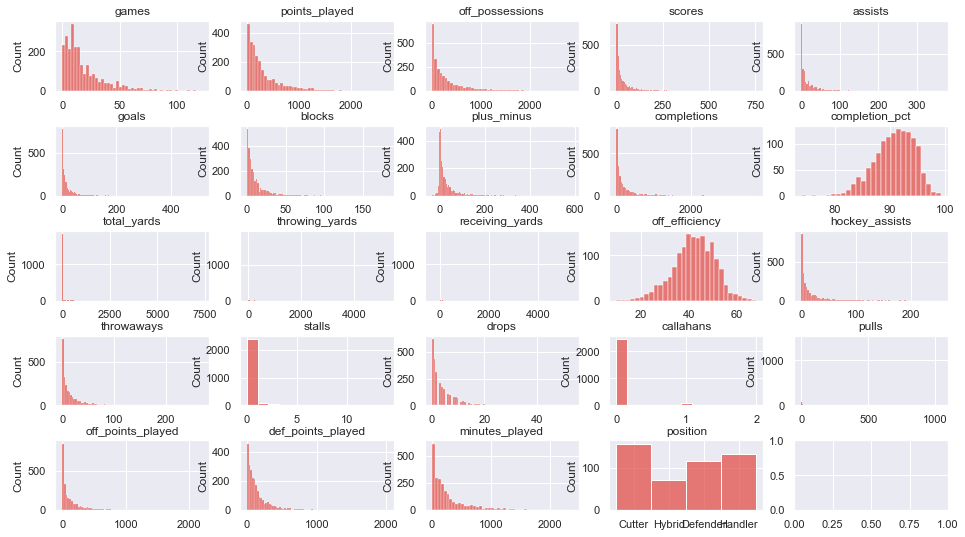

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

for col, ax in zip(odf.columns.drop('player'), ax.ravel()):
    sns.histplot(data=odf, x=col, ax=ax)

    # chart formatting
    ax.set_title(col)
    # ax.get_legend().remove()
    ax.set_xlabel("")

### Notes:
- Majority of distributions are heavily right skewed.
- The two distributions measuring efficiency (`off_efficiency` and `completion_pct`) are more normally distributed with some left skew
- Many stats have a very small number of players who have the highest categories
- Given `games` and `points_played` follow similar distributions, for this analysis the majority of attributes will be normalized by `points_played`.

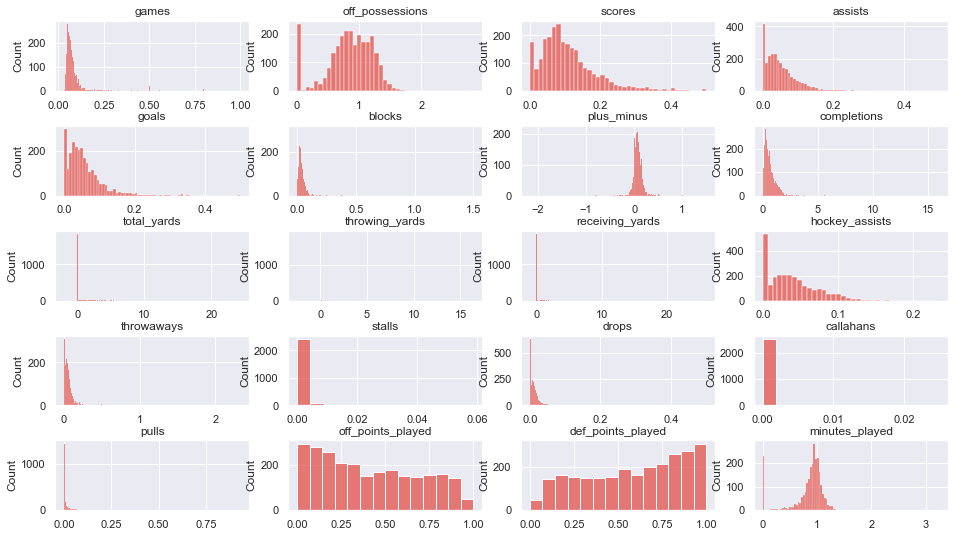

In [5]:
# Ignore percentage and categorical columns
cols_to_ignore = ['completion_pct', 'off_efficiency', 'position', 'player']
cols_to_keep = odf.columns.drop(labels=cols_to_ignore)

# Normalize by points played
norm_df = odf.loc[:, cols_to_keep].div(odf['points_played'], axis=0)

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

for col, ax in zip(norm_df.columns.drop(labels=['points_played']), ax.ravel()):
    sns.histplot(data=norm_df, x=col, ax=ax)

    # chart formatting
    ax.set_title(col)
    ax.set_xlabel("")


By normalizing by points played, the stats shown are more indicative of skill level when compared to other values. More points played = more opportunity and, without normalizing, players who've played more games/points will appear to be better in comparison to others who have not.

There are a lot of stats that show a high value count of '0' for that stat. This could be a select set of players who don't have very high stats. The subset of players  with 0 completions is analyzed below.

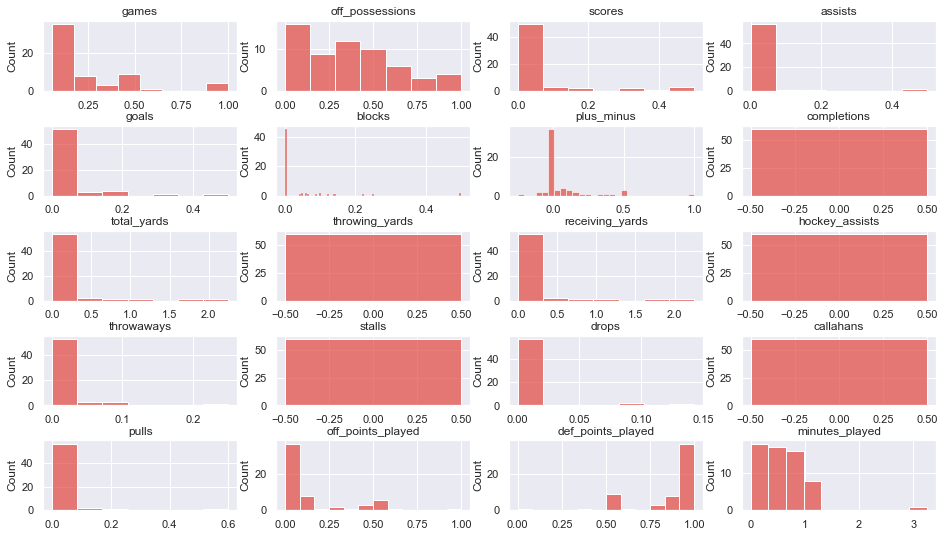

In [6]:
zero_comp = norm_df[norm_df['completions'] == 0]

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

for col, ax in zip(zero_comp.columns.drop(labels=['points_played']), ax.ravel()):
    sns.histplot(data=zero_comp, x=col, ax=ax)

    # chart formatting
    ax.set_title(col)
    ax.set_xlabel("")

There are 60 players who are noted as having no completions. This is suspicious because it's almost impossible to play multiple points in ultimate and not throw the disc to someone else for a single completion.

These 60 players account for 7 labeled players:
- 3 cutters
- 2 handlers
- 1 defender, and
- 1 hybrid

For now, all 60 entries will be kept in the data set.

In [7]:
del ax, col, fig, zero_comp

-------------------------------
# <a class="anchor" id="link3">Multivariate Analysis ✌🏿➕</a>
-------------------------------

## Correlation Heatmap

In [8]:
# Re-add columns removed for normalization & fill na
norm_df[cols_to_ignore] = odf[cols_to_ignore]
norm_df['position'] = norm_df['position'].fillna('unknown')

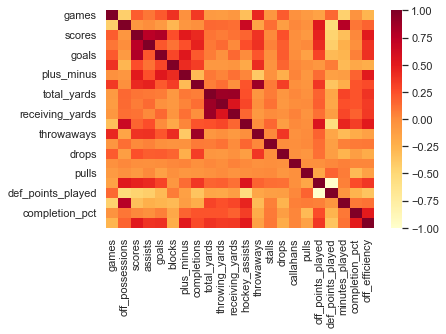

In [9]:
# Correlation Matrix
corr_df = norm_df.drop(labels='points_played', axis=1).corr()
sns.heatmap(corr_df, cmap='YlOrRd');

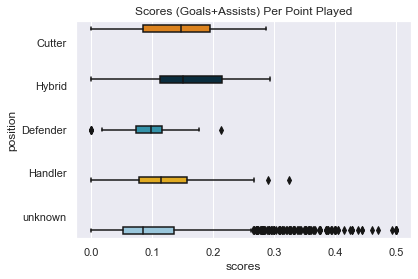

In [10]:
sns.boxplot(data=norm_df, x='scores', y='position', hue='position', palette=c_palette)
plt.title('Scores (Goals+Assists) Per Point Played')
plt.legend().remove()

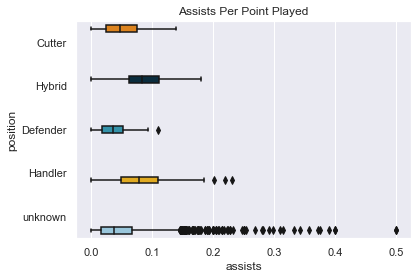

In [11]:
sns.boxplot(data=norm_df, x='assists', y='position', hue='position', palette=c_palette)
plt.title('Assists Per Point Played')
plt.legend().remove()

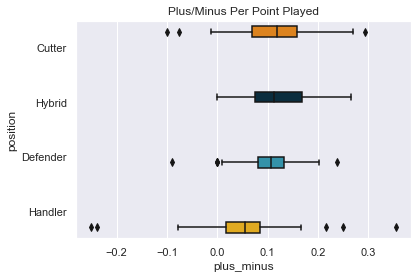

In [12]:
# Plus/Minus - 'Unknown' category removed due to high number of outliers
sns.boxplot(data=norm_df[norm_df['position'] != 'unknown'], 
            x='plus_minus', y='position', 
            hue='position', palette=c_palette)
plt.title('Plus/Minus Per Point Played')
plt.legend().remove()

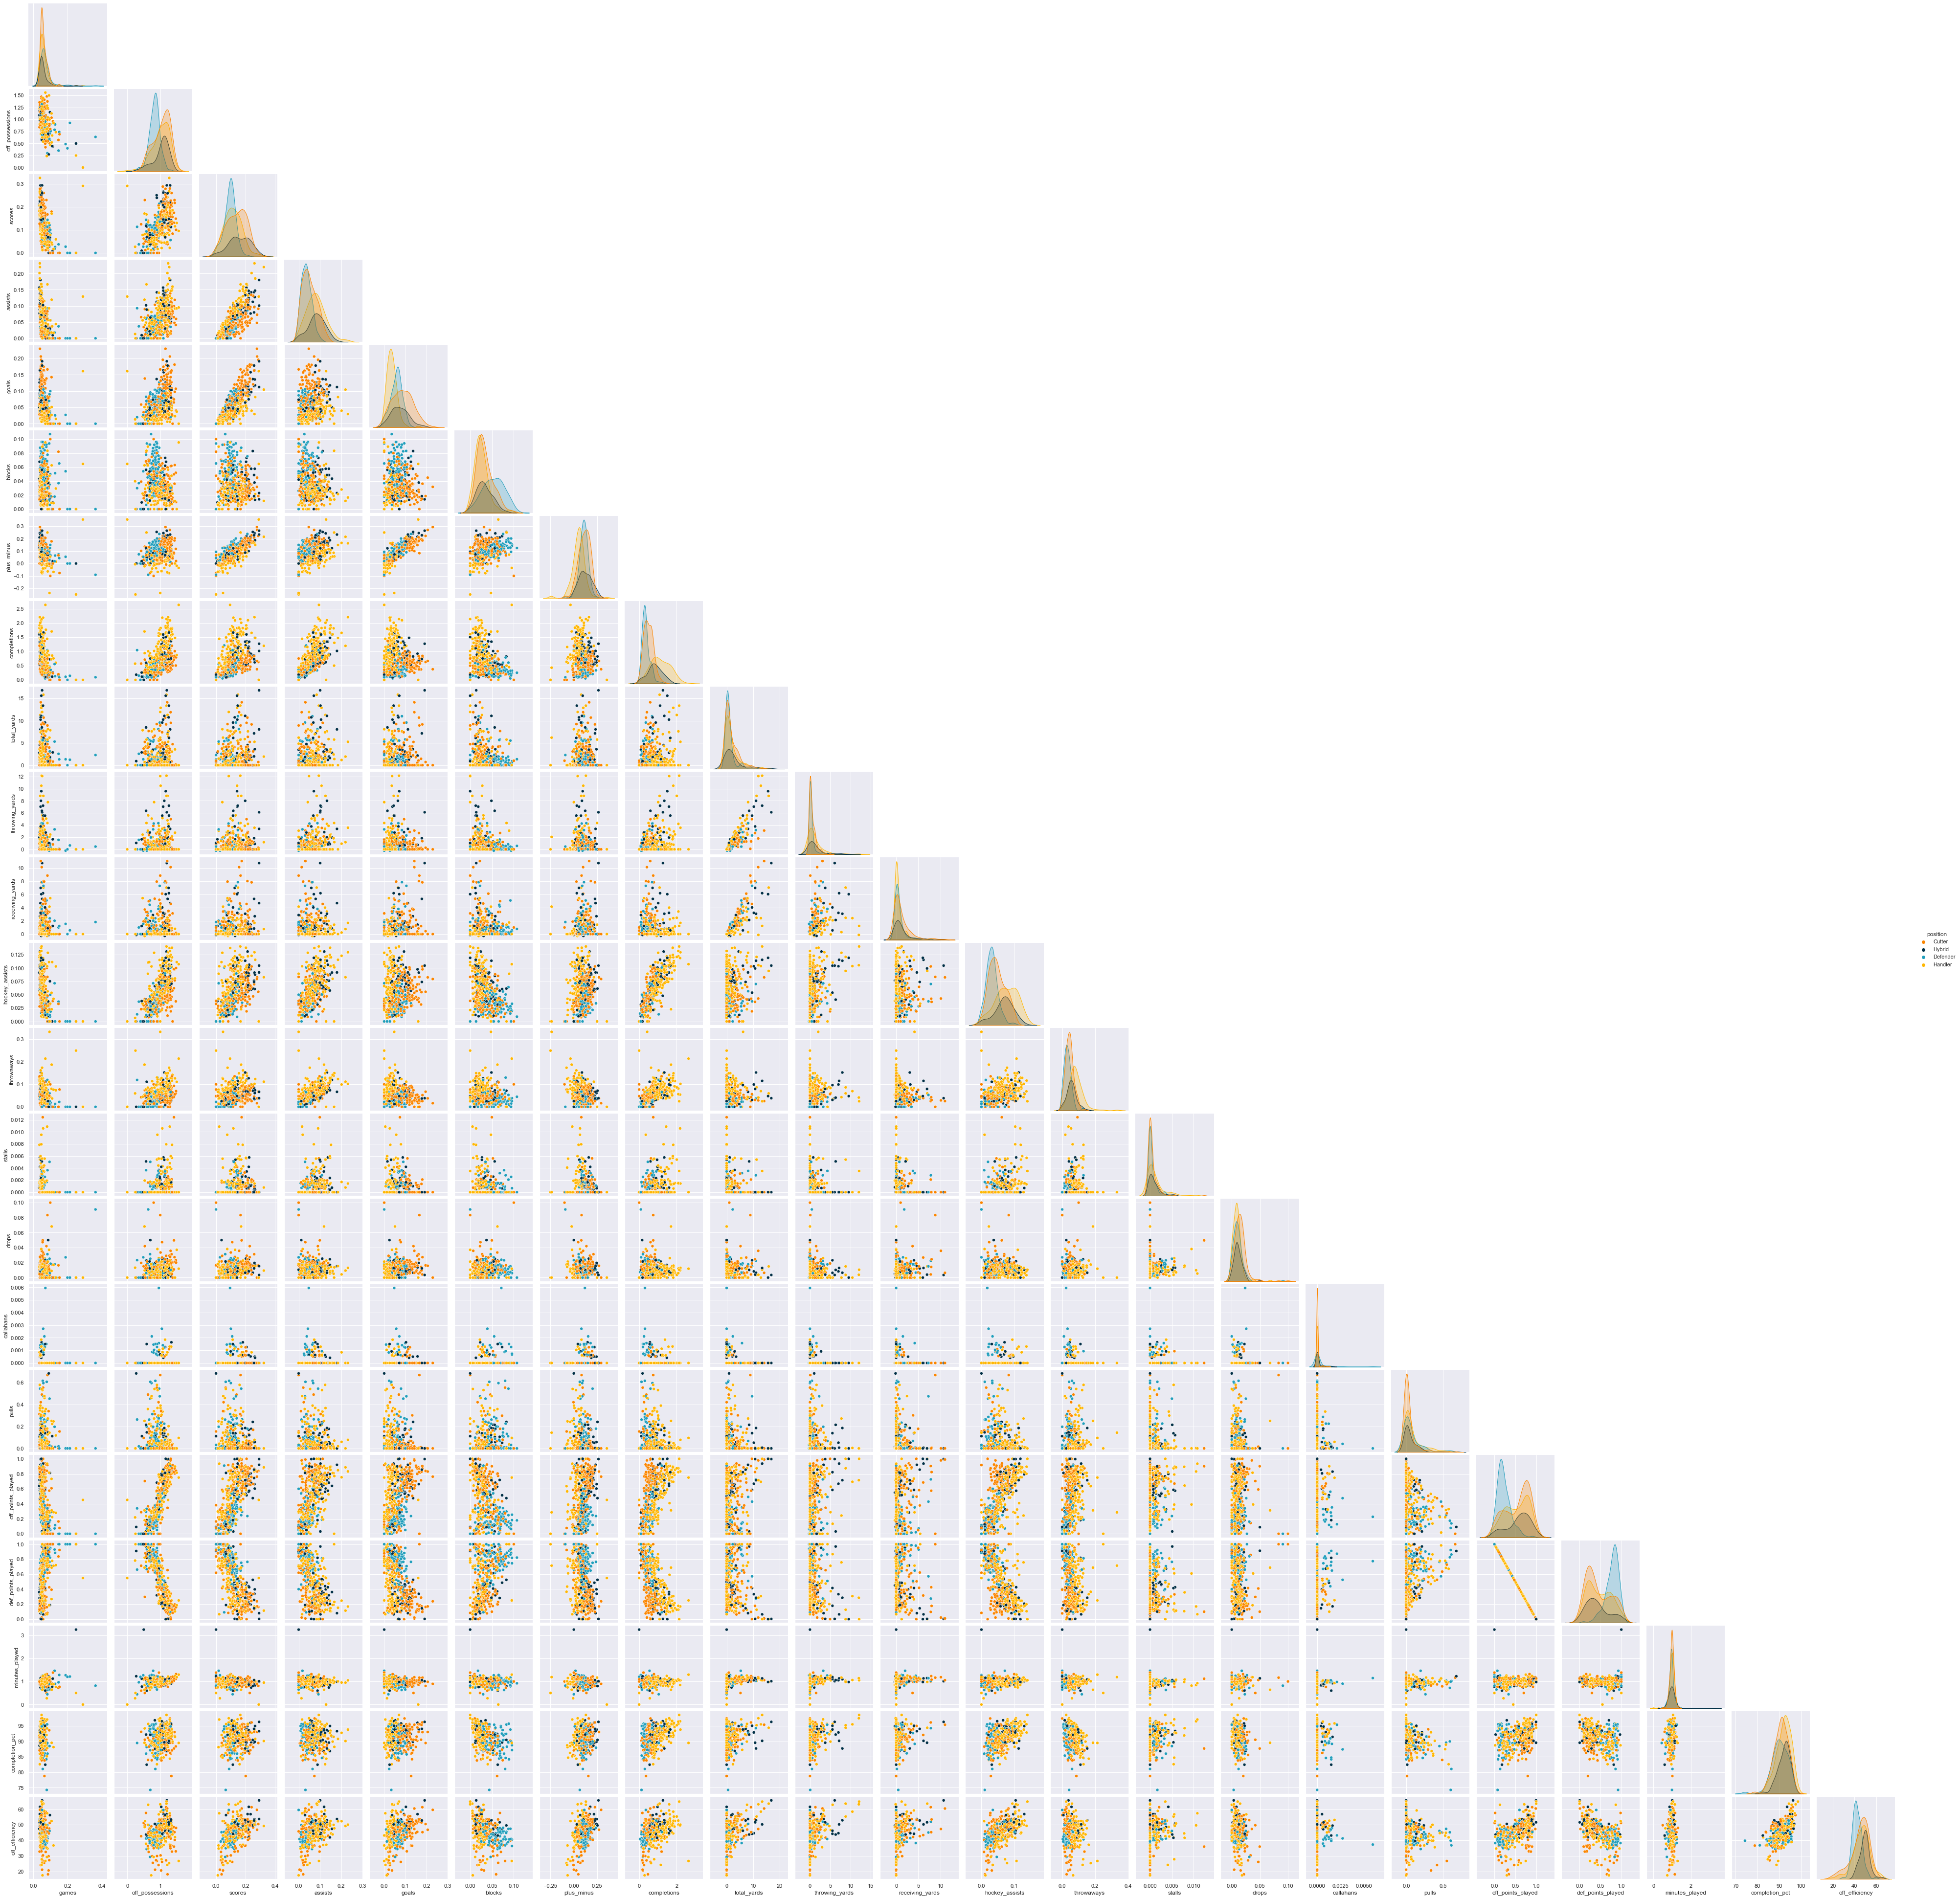

In [13]:
# Pairplot 
sns.pairplot(data=norm_df[norm_df['position'] != 'unknown'].drop(labels='points_played', axis=1), 
             hue='position', 
             palette=c_palette, 
             corner=True);

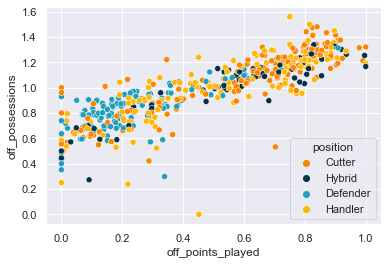

In [14]:
sns.scatterplot(data=norm_df[norm_df['position'] != 'unknown'], 
                x='off_points_played', 
                y='off_possessions', 
                hue='position',
                palette=c_palette);

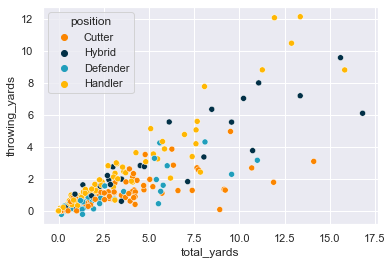

In [15]:
sns.scatterplot(data=norm_df[norm_df['position'] != 'unknown'], 
                x='total_yards', 
                y='throwing_yards', 
                hue='position',
                palette=c_palette);

### Notes
- High correlation between throwing_yards, total_yards, and receiving_yards
- High correlation between completions and throwaways
- High correlation between offensive possesions, hockey_assists, and minutes_played

Given several areas of high correlation, it is in good interest to remove several columns before performing linear regression.

- The shown pairplot indicates good segmentation between certain classes like handler and cutter. The 'unknown' category is not included because the majority of players are 'unknown' and it makes it more difficult to see patterns among the already labeled data points.
- Although there is some existing division among players, the differences among the player categories is not fully apparent.

In the next section, the following steps are taken to further prepare the data for various forms of supervised learning.
- Principle Component Analysis (PCA) with and without a standard scaler

In [28]:
# Drop entry 2161, all values are null
norm_df = norm_df.drop(labels=2161, axis=0)

# Drop columns with high na values
norm_df = norm_df.drop(labels=['completion_pct', 'off_efficiency'], axis=1)

----------
# Scaling & Check for Collinearity
----------

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [29]:
# Scale and repeat Sample
temp = norm_df.drop(labels=['position', 'player'], axis=1).copy(deep=True)
scaler: StandardScaler = StandardScaler()
scaler.fit(temp)
scaled_array = scaler.transform(temp)

scaled_df = pd.DataFrame(scaled_array, columns=[i for i in norm_df.columns if i not in ['position', 'player']])
scaled_df = scaled_df.drop(labels='points_played', axis=1)

In [31]:
scaled_df.sample(5, random_state=92)

games  off_possessions    scores   assists     goals    blocks  \
2004  0.199184        -0.111178 -1.332878 -1.019393 -1.056514 -0.099681   
278  -0.449336         1.093204  0.857273  0.127625  1.159605 -0.386635   
409  -0.478179         0.985264  0.473619  0.223210  0.501812 -0.284659   
1835 -0.013429         1.065359 -0.306283  0.100700 -0.547314  0.212959   
689  -0.177919        -0.040667 -0.796935 -0.946299 -0.325475  0.721841   

      plus_minus  completions  total_yards  throwing_yards  receiving_yards  \
2004   -0.357840    -0.724113    -0.394082       -0.332622        -0.362159   
278     0.236800    -0.144892    -0.394082       -0.332622        -0.362159   
409     0.475311     0.275271    -0.394082       -0.332622        -0.362159   
1835   -0.289566     0.244621    -0.394082       -0.332622        -0.362159   
689     0.437440    -0.792008    -0.394082       -0.332622        -0.362159   

      hockey_assists  throwaways    stalls     drops  callahans     pulls  \
2004       -1.174285   -0.636377 -0.272669 -0.638700  -0.117867 -0.433987   
278         0.148183    0.193683 -0.272669 -0.098876  -0.117867 -0.351385   
409         1.460517   -0.325372 -0.272669 -0.154720  -0.117867 -0.211816   
1835        0.547614    0.379867 -0.272669 -0.638700  -0.117867  0.654966   
689        -0.724819   -0.598482 -0.272669 -0.308455  -0.117867 -0.402404   

      off_points_played  def_points_played  minutes_played  
2004          -1.082600           1.082600       -0.345197  
278            1.229911          -1.229911        0.408576  
409            0.763085          -0.763085        0.486482  
1835           0.141224          -0.141224        1.170793  
689           -1.175085           1.175085        0.009884

In [32]:
vif_data = scaled_df[[i for i in scaled_df.columns if i not in cols_to_ignore]]
vif_values = pd.DataFrame()

vif_values['Attribute'] = vif_data.columns
vif_values['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_data.columns))]
vif_values

c:\Users\Geoffrey\Documents\GitHub\audl_ds\.venv3.9.4\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Attribute       VIF
0               games  1.639674
1     off_possessions  8.009513
2              scores       inf
3             assists       inf
4               goals       inf
5              blocks       inf
6          plus_minus       inf
7         completions  7.053596
8         total_yards       inf
9      throwing_yards       inf
10    receiving_yards       inf
11     hockey_assists  2.623460
12         throwaways       inf
13             stalls  1.040525
14              drops       inf
15          callahans  1.009410
16              pulls  1.083446
17  off_points_played       inf
18  def_points_played       inf
19     minutes_played  6.058832

In [34]:
# After some trial and error, final list of removed columns
drop_cols = ['points_played', 'goals', 'scores', 'total_yards', 'def_points_played']

vif_data = scaled_df[[i for i in scaled_df.columns if i not in drop_cols]]
vif_values = pd.DataFrame()

vif_values['Attribute'] = vif_data.columns
vif_values['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_data.columns)) ]
vif_values

Attribute       VIF
0               games  1.639674
1     off_possessions  8.009513
2             assists  2.790454
3              blocks  4.467642
4          plus_minus  6.028099
5         completions  7.053596
6      throwing_yards  1.734726
7     receiving_yards  1.730840
8      hockey_assists  2.623460
9          throwaways  9.894294
10             stalls  1.040525
11              drops  1.394516
12          callahans  1.009410
13              pulls  1.083446
14  off_points_played  3.971118
15     minutes_played  6.058832

------------
# Data Prep for Modeling
------------

In [51]:
# Separate Independant and Dependant
y = norm_df['position'].astype('category')
X = vif_data.copy(deep=True)

y_labels = y.unique()
idx2class = {}
class2idx = {}

i = 0

for label in y_labels:
    idx2class[i] = label
    class2idx[label] = i

    i+=1

y = y.replace(to_replace=class2idx)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=92, stratify=y)

-----------------------
# PCA
-----------------------

In [57]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [58]:
X_train_pca

array([[-0.91908237,  0.7390331 ],
       [ 0.1303308 ,  2.35283396],
       [ 1.01596519, -1.78626892],
       ...,
       [-0.3302732 , -0.1200505 ],
       [-1.07547359,  1.15056729],
       [-1.95019869,  0.85303611]])

In [60]:
print(f"The explained variance ratios using raw data is {pca.explained_variance_ratio_}")

The explained variance ratios using raw data is [0.21618302 0.16949886]


In [66]:
X_train_pca_labeled = pd.DataFrame(X_train_pca, columns=['x1','x2'])
X_train_pca_labeled = X_train_pca_labeled.merge(right=norm_df['position'], how='left', left_index=True, right_index=True)
X_train_pca_labeled.sample(4, random_state=92)

x1        x2  position
1197 -1.614374  1.148487   unknown
1575  0.621736 -1.304418   unknown
1121 -1.525429  0.600099   unknown
208  -3.971633  2.069653  Defender

Text(0.5, 1.0, 'Raw PCA (n=2)')

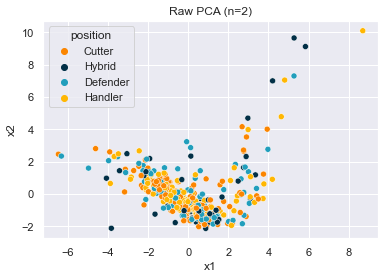

In [68]:
sns.scatterplot(data=X_train_pca_labeled[X_train_pca_labeled['position'] != 'unknown'], x='x1', y='x2', hue='position', palette=c_palette)
plt.title('Raw PCA (n=2)')

*NOTES:*
- 
- 
- 


As expected, there's a lot of collinearity within the data. As one example, `scores` is equal to `assists` + `goals`. The below cells are created to experiment with dropping some of the columns that have inf VIF to see how VIF values change.

---------------------------
# <a class="anchor" id="linkLR">K Means and KNN</a>
---------------------------

In [ ]:
# IMPORTS
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [ ]:
# Data Prep
unknown_idx = df[df['position'] == 'unknown'].index

scaled_df.drop(labels='points_played', axis=1, inplace=True)
df.drop(labels=['points_played', 'position'], axis=1, inplace=True)

scaled_df.drop(labels=unknown_idx, inplace=True, axis=0)
df.drop(labels=unknown_idx, inplace=True, axis=0)

# KMeans
scaled_kmeans = KMeans(n_clusters=4, random_state=92).fit(scaled_df)
raw_kmeans = KMeans(n_clusters=4, random_state=92).fit(df)

In [ ]:
print("SCALED KMEANS")
for i in range(4):
    print(f"LABEL: {i} -- COUNT: {list(scaled_kmeans.labels_).count(i)}")

print("*"*20)

print("RAW KMEANS")
for i in range(4):
    print(f"LABEL: {i} -- COUNT: {list(raw_kmeans.labels_).count(i)}")

In [ ]:
df['_km_labels'] = scaled_kmeans.labels_

In [ ]:
df['position'] = full_df['position']

# Add 'unknown' to position
df['position'] = df['position'].fillna('unknown')

In [ ]:
for i in range(4):
    print(f"Label: {i}")

    for p in ['Cutter', 'Handler', 'Defender', 'Hybrid']:
        temp = df[(df['position'] == p) & (df['_km_labels'] == i)]
        total = len(df[df['position'] == p])
        print(f"\t -{p}: {round(100*len(temp)/total,2)}%")

- In both cases (raw data v. scaled), the classes are highly imbalanced and are likely not very indicative of actual differentiations between players. The scaled k-means fit is slightly less imbalanced with two primary clusters arising. 

- Defenders appear to be easily identifiable based on stats. Over 90% of defenders (105/116) were placed under Label #1. This category is not a 'catch all' category because the majority of players from all other categories are under Label # 3. The results indicate that differentiation defenders is easier based on the provided stats, but separating handlers, cutters, and hybrid players may be more difficult.

- Given the two examples above, the raw data performs better when clustering. This will be the data set used moving forward.

-----------------------------
# KNN
-----------------------------

In [ ]:
n = 10
score = []
for i in range(1,n+1):
    neighbors = KNeighborsClassifier(n_neighbors=i)
    nca = NeighborhoodComponentsAnalysis(random_state=92)

    nca_pipe = Pipeline([('nca', nca), ('knn', neighbors)])
    nca_pipe = nca_pipe.fit(X_train, y_train)
    score.append(nca_pipe.score(X_test, y_test))

sns.scatterplot([i for i in range(1, n+1)], score)

- In a KNN Classifier, the optimal number of neighbors appears to be 8 when looking at k<=10

--------------------------
# Random Forest
--------------------------

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [ ]:
dt_model = DecisionTreeClassifier(criterion='gini', random_state=92)
dt_model.fit(X_train, y_train)

In [ ]:
# accuracy on training set
print("Accuracy on train set", dt_model.score(X_train, y_train))

# accuracy on test set
print("Accuracy on test set", dt_model.score(X_test, y_test))

In [ ]:
feature_names = list(X_train.columns)
plt.figure(figsize=(20,30))

out = tree.plot_tree(dt_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [ ]:
importances = dt_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#TODO: Check existing notebook for removal of collinear columns, create section **ABOVE DECISION TREE** to remove any collinear columns
#TODO: Re-do XGBoost with F1 score as metric

In [ ]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=92)

# Grid of parameters to choose from

parameters = {'max_depth': np.arange(1,7), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [5, 10,15,20,25,30],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(X_train, y_train)

---------------------------
# <a class="anchor" id="linkR">Resources 🕸</a>
---------------------------
1. [The AUDL Website](https://theaudl.com/)
2. ['AUDL 2019: Closer than Ever'](https://theaudl.com/league/news/2019-audl-closer-ever-competition)
3. ['AUDL Announces 2022 Schedule, Championship Weekend Back in Madison](https://ultiworld.com/2022/02/21/audl-announces-2022-schedule-championship-weekend-back-in-madison/#:~:text=Along%20with%20the%20return%20of,Lake%20Shred%2C%20and%20Colorado%20Summit)

### DATA NOTES:
- It's very possible for players to switch positions as they progress. Unfortunately the labeled data for players is not by season. If a player switches from cutter to handler, and they are labeled as a handler, their stats likely aren't fully indicative of a typical handler's stats.
- Assumption: The labeled players are a good representation of a random selection of players with significant playtime from the league.
- The quantity and quality of data collected has improved significantly as the AUDL has had more and more seasons.